# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
  Using cached ipywidgets-7.7.0-py2.py3-none-any.whl (123 kB)
  Using cached widgetsnbextension-3.6.6-py2.py3-none-any.whl (1.6 MB)


  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.10
    Uninstalling widgetsnbextension-4.0.10:
      Successfully uninstalled widgetsnbextension-4.0.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.2
    Uninstalling ipywidgets-8.1.2:
      Successfully uninstalled ipywidgets-8.1.2
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: jupyter in /root/.local/lib/python3.7/site-packages (1.0.0)
  Using cached ipywidgets-8.1.2-py3-none-any.whl (139 kB)
  Using cached widgetsnbextension-4.0.10-py3-none-any.whl (2.3 MB)


  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.0
    Uninstalling ipywidgets-7.7.0:
      Successfully uninstalled ipywidgets-7.7.0
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
import time

In [4]:
# Check if CUDA is available and set the device accordingly
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])  # Use Lambda to apply torch.flatten


# Create training set and define training dataloader
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

# I chose to convert the data to tensors, normalize, and flatten the data.
# Converting to tensors allows to use the data with PyTorch.
# Normalization helps to speed up the training process.
# Flattening the data is necessary because our neural network expects the input to be a one-dimensional vector.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:10]
    images = batch[0][0:10]
    for i in range(10):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

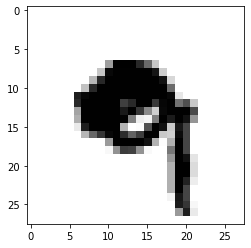

In [7]:
# Explore data
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(images[0].numpy().squeeze().reshape(28, 28), cmap='gray_r')  # Reshape the flattened image


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
losses = []
epochs = 10


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

Epoch: 1/10, Time: 13.93s, Loss: 1.1488, Accuracy: 76.37%


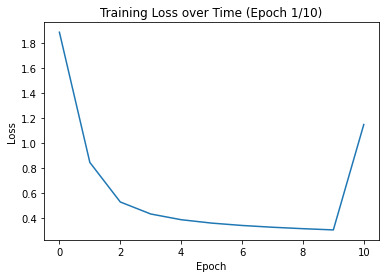

Epoch: 2/10, Time: 13.56s, Loss: 0.5291, Accuracy: 86.78%


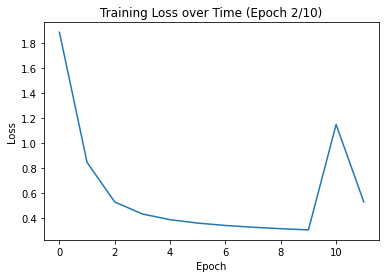

Epoch: 3/10, Time: 13.26s, Loss: 0.4263, Accuracy: 88.49%


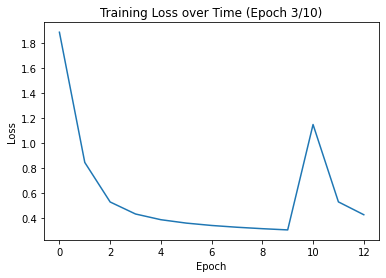

Epoch: 4/10, Time: 12.95s, Loss: 0.3826, Accuracy: 89.34%


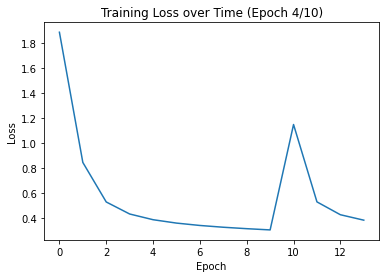

Epoch: 5/10, Time: 12.83s, Loss: 0.3568, Accuracy: 89.91%


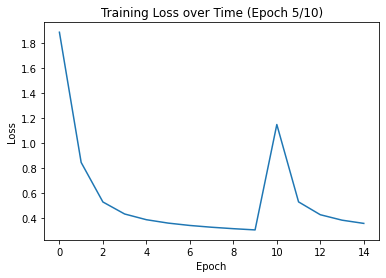

Epoch: 6/10, Time: 13.05s, Loss: 0.3391, Accuracy: 90.35%


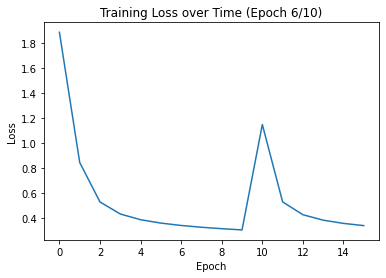

Epoch: 7/10, Time: 12.79s, Loss: 0.3253, Accuracy: 90.74%


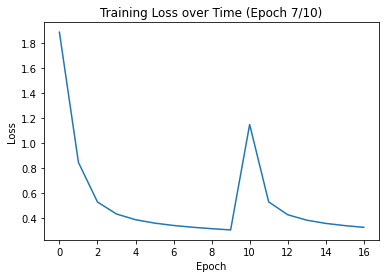

Epoch: 8/10, Time: 12.16s, Loss: 0.3145, Accuracy: 91.08%


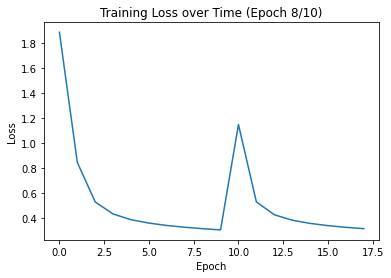

Epoch: 9/10, Time: 12.16s, Loss: 0.3049, Accuracy: 91.33%


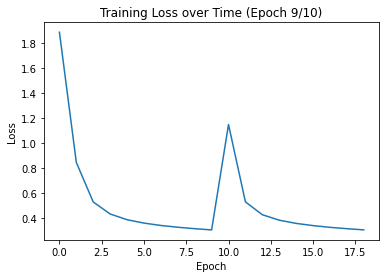

Epoch: 10/10, Time: 12.15s, Loss: 0.2964, Accuracy: 91.57%


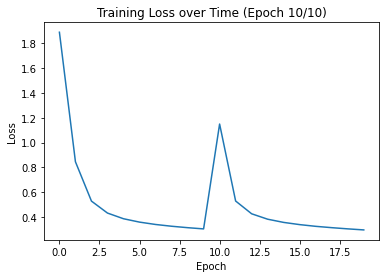

In [15]:
model.to(device)
# Initialize a list to hold the losses
# Create a figure for the plot
fig, ax = plt.subplots()
for e in range(epochs):
    start_time = time.time()
    running_loss = 0
    correct_count, all_count = 0, 0    
    for images, labels in trainloader:
        # Move images and labels to the GPU if available
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities
        log_ps = model(images)
        
        # Calculate the loss with the logps and the labels
        loss = criterion(log_ps, labels)
        
        # Backward pass to calculate the gradients
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(log_ps.data, 1)
        all_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()
        
        
    # Record the loss for each epoch
    losses.append(running_loss/len(trainloader))

    # Clear the previous plot
    ax.clear()
    
    # Print the progress of each epoch
    print(f"Epoch: {e+1}/{epochs}, Time: {time.time()-start_time:.2f}s, Loss: {running_loss/len(trainloader):.4f}, Accuracy: {correct_count/all_count*100:.2f}%")
    
    # Plot the losses
    plt.plot(losses)
    plt.title(f"Training Loss over Time (Epoch {e+1}/{epochs})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show(block=False)
    plt.pause(0.1)
# # Plot the training loss
# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss over Time')
# plt.show()


Plot the training loss (and validation loss/accuracy, if recorded).

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Testing your model
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784).to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9185


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
# Define the model with less complexity
model = nn.Sequential(nn.Linear(784, 800),  # First layer with 800 nodes
                      nn.ReLU(),
                      nn.Linear(800, 10),  # Second layer
                      nn.LogSoftmax(dim=1))

model.to(device)

# Specify a loss function and an optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=0.001)  # added weight decay for L2 regularization

## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
torch.save(model.state_dict(), 'model.pth')

In [16]:
losses

[1.8878147300880854,
 0.845019728771405,
 0.52838052802884,
 0.4321245702503841,
 0.3863812635130465,
 0.35925097582436827,
 0.3402444911378025,
 0.32601797165297497,
 0.31448243984154295,
 0.30459823174231343,
 1.1487508654785055,
 0.5290903949788385,
 0.4262514645928767,
 0.38262614871520223,
 0.356811626887779,
 0.33907242328214493,
 0.32528593732731176,
 0.31449089675093256,
 0.304905047175536,
 0.29641393684089057]